In [98]:
import pandas as pd
import geopandas as gpd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import math

import pyproj

In [34]:
# Paths
lcf_path = Path.cwd() / 'ExampleImages' / 'Juvika_June2022_Pika_L_12.lcf'
times_path = lcf_path.parent / (lcf_path.stem + '.bil.times')
print(times_path)

/home/mha114/Dropbox/Python/massimal/prelim/georef_world_file/ExampleImages/Juvika_June2022_Pika_L_12.bil.times


In [38]:
# Load LCF data
lcf_data = np.loadtxt(lcf_path)
lcf_times = lcf_data[:,0] - lcf_data[0,0]
lcf_long = lcf_data[:,4]
lcf_lat = lcf_data[:,5]
lcf_alt = lcf_data[:,6]



In [111]:
# Load image .times data (time for each image line)
image_times = np.loadtxt(times_path)
image_times = image_times - image_times_raw[0]
image_dt = np.mean(np.diff(image_times))
print(f'{image_dt=}')

image_dt=0.009174305652826458


In [40]:
print(f'{lcf_times.shape=}')
print(f'{image_times.shape=}')

lcf_times.shape=(3668,)
image_times.shape=(2000,)


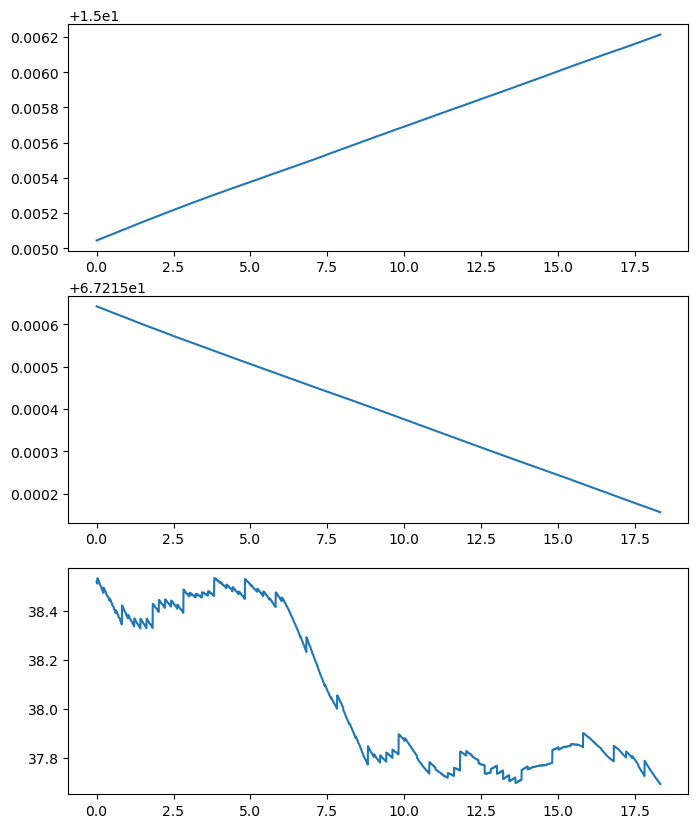

In [49]:
fig, ax = plt.subplots(nrows=3,figsize=(8,10))
ax[0].plot(lcf_times,lcf_long)
ax[1].plot(lcf_times,lcf_lat)
ax[2].plot(lcf_times,lcf_alt)
plt.show()

In [52]:
geometry=gpd.points_from_xy(lcf_long, lcf_lat, crs='EPSG:4326')

In [56]:
geomatry_utm = geometry.to_crs()

array([67.21564225, 67.2156421 , 67.21564197, ..., 67.21515659,
       67.21515646, 67.21515633])

In [ ]:
# gdf = gpd.GeoDataFrame(
#     lcf_data,
#     crs = 'EPSG:4326',
#     geometry=geopandas.points_from_xy(data.Lng, data.Lat))


In [73]:
def convert_long_lat_to_utm(long,lat,return_utm_epsg=False):
    """ Convert longitude and latitude coordinates (WGS84) to UTM 
    
    # Input parameters:
    long:
        Longitude coordinate(s), scalar or array
    lat:
        Latitude coordinate(s), scalar or array
    return_utm_epsg:
        The UTM zone is automatically estimated based on coordinates.
        If return_utm_epsg=True, the EPSG code for the UTM zone is returned

    Returns:
    UTMx:
        UTM x coordinate ("Easting"), scalar or array
    UTMx:
        UTM x coordinate ("Easting"), scalar or array
    UTM_epsg (only if return_utm_epsg=True):
        EPSG code (integer) for UTM zone    
    """
    utm_crs_list = pyproj.database.query_utm_crs_info(
        datum_name="WGS 84",
        area_of_interest = pyproj.aoi.AreaOfInterest(
            west_lon_degree=min(long),
            south_lat_degree=min(lat),
            east_lon_degree=max(long),
            north_lat_degree=max(lat),
        ),
    )
    utm_crs = pyproj.CRS.from_epsg(utm_crs_list[0].code)
    proj = pyproj.Proj(utm_crs)
    UTMx, UTMy = proj(lcf_long,lcf_lat)
    if return_utm_epsg:
        return UTMx, UTMy, utm_crs.to_epsg()
    else:
        return UTMx, UTMy

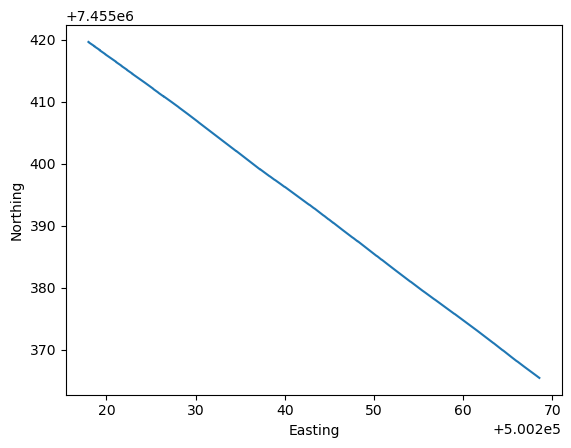

In [80]:
x,y = convert_long_lat_to_utm(lcf_long,lcf_lat)
plt.plot(x,y)
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.show()

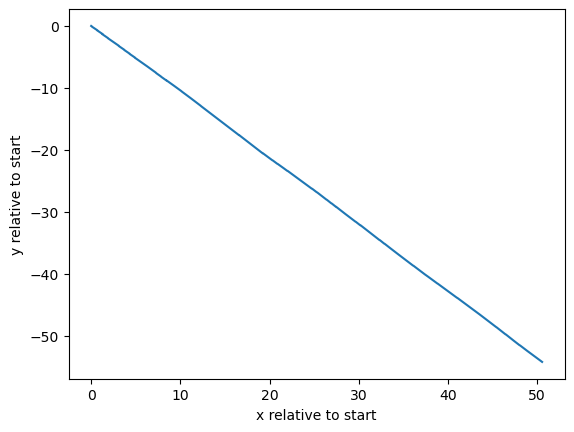

In [81]:
x_rel = x - x[0]
y_rel = y - y[0]
plt.plot(x_rel,y_rel)
plt.xlabel('x relative to start')
plt.ylabel('y relative to start')
plt.show()

In [82]:
np.diff(image_times)

array([0.009175, 0.009174, 0.009174, ..., 0.009175, 0.009174, 0.009174])

In [93]:
vx = np.mean(np.diff(x)) / np.mean(np.diff(lcf_times))
vy = np.mean(np.diff(y)) / np.mean(np.diff(lcf_times))
v_abs = np.linalg.norm((vx,vy))
print(f'{vx=}, {vy=}, {v_abs=}')


vx=2.756638037158196, vy=-2.9542453088247322, v_abs=4.040621067685057


In [120]:
d = np.array((vx,vy)) / v_abs
d_rot90cw = np.array([-d[1],d[0]]) # Rotate 90 clockwise: (x,y) -> (-y,x)
d_rot90ccw = np.array([d[1],-d[0]]) # Rotate 90 counterclockwise: (x,y) -> (y,-x)
print(d)
print(d_rot90ccw)

[ 0.68223127 -0.73113644]
[-0.73113644 -0.68223127]


In [115]:
def pushbroom_width_on_ground(opening_angle_deg,relative_altitude):
    """ Calculate width of pushbroom camera footprint on ground 
    
    # Input arguments:
    opening_angle_deg:
        Opening angle of camera in degrees
    relative_altitude:
        Altitude of camera relative to ground

    Returns:
    width:
        Width of pushbroom camera image on ground
        Units are the same as the units used for relative altitude.

    # Notes:
    - Assumes that camera is perfectly "centered" (no roll), 
    and that ground is perfectly flat. 
    """
    return 2*math.tan(math.radians(opening_angle_deg/2))*relative_altitude

In [117]:
L = pushbroom_width_on_ground(opening_angle_deg=36.5, relative_altitude=np.mean(lcf_alt))
print(f'{L=}')


L=25.098320718004654


In [118]:
r_start_mid = np.array((x[0],y[0]))
r_start_origin = r_start_mid + (L/2)*d_rot90ccw
print(f'{r_start_mid=}')
print(f'{r_start_origin=}')


r_start_mid=array([ 500217.98520084, 7455419.63619666])
r_start_origin=array([ 500208.8100524 , 7455411.07476707])


In [119]:
dx = vx*image_dt
dy = vy*image_dt
print(f'{dx=}, {dy=}')

dx=0.025290239927096874, dy=-0.027103149436586788


In [122]:
u_at = np.array((vx,vy)) / v_abs        # Unit vector in along-track direction
u_ct = np.array([-u_at[1],u_at[0]])     # Unit vector in cross-track direction
print(f'{u_at=}, {u_ct=}')

u_at=array([ 0.68223127, -0.73113644]), u_ct=array([0.73113644, 0.68223127])


In [132]:
def world_file_from_lcf_times_files(lcf_file_path,times_file_path,world_file_path,
                                    n_crosstrack_pixels=900,camera_opening_angle_deg=36.5,
                                    altitude_offset=0):
    """ Calculate world file (affine transformation) for raster image based on .lcf and .times files 
    
    # Input parameters:
    lcf_file_path:
        Path to .lcf file, containing camera IMU and GNSS information
        It is assumed that 
        - Column 1 contains times in units of seconds
        - Column 4 contains longitude in (decimal) degrees
        - Column 5 contains latitude in (decimal) degrees
        - Column 6 contains altitude in meters relative to WGS-54 ellipsoid
    times_file_path:
        Path to .times file. It is assumed that has a single column,
        containing timestamps for every line for the image.
    world_file_path:
        Path for output world file. Should have file extension corresponding to
        image format, e.g. 'pgw' for PNG files, or, alternatively,
        just 'wld' (accepted by GDAL and QGIS). 
         
    # Keyword parameters:
    n_crosstrack_pixels:
        Number of pixels "cross-track" (also called number of "samples")
    camera_opening_angle_deg:
        Opening angle of pushbroom camera in degrees.
    altitude_offset:
        Offset between altitude as measured by camera in LCF file, and actual altitude.
        Example: If LCF file altitude was 30 meters, and actual altitude was 35 meters,
        set altitude_offset = 5 m. Actual altitude is calculated as 
        mean LCF altitude + altitude_offset.

    # Notes:
    The "world file" parameters are written to 
        6-element tuple containing parameters for "world file" affine transformation
        world_file_parameters = (A, D, B, E, C, F), where
        A: x-component of the pixel width (x-scale)
        D: y-component of the pixel width (y-skew)
        B: x-component of the pixel height (x-skew)
        E: y-component of the pixel height (y-scale)
        C: x-coordinate of the center of image's upper left pixel 
        F: y-coordinate of the center of image's upper left pixel
        All values are in the units of the map coordinate system (here: UTM)

        The parameters are part of an affine transformation given by
            x = A*ix + B*iy + C
            y = E*ix + E*iy + F
        where ix and iy are the column and row indices of the raster image, respectively.
    """

    # Load LCF data
    lcf_data = np.loadtxt(lcf_file_path)
    lcf_times = lcf_data[:,0] - lcf_data[0,0] # Use time relative to first timestamp
    lcf_long = lcf_data[:,4]
    lcf_lat = lcf_data[:,5]
    lcf_alt = lcf_data[:,6]
    # TODO: Include pitch and roll data from LCF

    # Load image .times data (time for each image line)
    image_times = np.loadtxt(times_file_path)
    image_times = image_times - image_times[0]  # Use time relative to first timestamp
    image_dt = np.mean(np.diff(image_times))

    # Convert coordinates to UTM (x,y)
    x,y = convert_long_lat_to_utm(lcf_long,lcf_lat)

    # Calculate along-track velocity vector, and corresponding unit vector
    vx_alongtrack = (x[-1] - x[0]) / (lcf_times[-1] - lcf_times[0])
    vy_alongtrack = (y[-1] - y[0]) / (lcf_times[-1] - lcf_times[0])
    v_alongtrack = np.array((vx_alongtrack,vy_alongtrack))
    u_alongtrack = v_alongtrack / np.linalg.norm(v_alongtrack)
    
    # Calculate cross-track unit vector
    u_crosstrack = np.array([-u_alongtrack[1],u_alongtrack[0]]) # Rotate 90 clockwise: (x,y) -> (-y,x)

    # Calculate length of pushbroom "footprint" on ground
    altitude = np.mean(lcf_alt) + altitude_offset
    L = pushbroom_width_on_ground(opening_angle_deg=camera_opening_angle_deg,
                                  relative_altitude=altitude)
    
    # Calculate "origin" (coordinates for upper left pixel in image)
    r_origin = np.array([x[0], y[0]]) - (L/2)*u_crosstrack
    C,F = r_origin

    # Calculate B (x-skew) and E (y-scale)
    B = vx_alongtrack*image_dt
    E = vy_alongtrack*image_dt

    # Calculate A (x-scale) and D (y-skew)
    cross_track_gsd = L/n_crosstrack_pixels  # Distance between pixels cross-track
    A,D = cross_track_gsd * u_crosstrack

    # Save to file
    world_file_parameters = np.array((A,D,B,E,C,F))
    print(f'{world_file_parameters=}')
    np.savetxt(world_file_path,world_file_parameters,fmt='%.12f')


In [136]:
world_file_path = lcf_path.parent / (lcf_path.stem + '.wld')
print(world_file_path)
world_file_from_lcf_times_files(lcf_file_path=lcf_path,times_file_path=times_path,world_file_path=world_file_path)


/home/mha114/Dropbox/Python/massimal/prelim/georef_world_file/ExampleImages/Juvika_June2022_Pika_L_12.wld
